In [1]:
!pip install SimPEG==0.11.6
!pip install git+https://github.com/simpeg/tle-magnetotelluric_inversion
!pip install pymatsolver

     |████████████████████████████████| 238 kB 5.2 MB/s 
     |████████████████████████████████| 52 kB 715 kB/s 
     |████████████████████████████████| 704 kB 47.9 MB/s 
     |████████████████████████████████| 156 kB 65.6 MB/s 
     |████████████████████████████████| 211 kB 63.0 MB/s 
  Created wheel for SimPEG: filename=SimPEG-0.11.6-py3-none-any.whl size=290020 sha256=6100b28ad837fc5603f368b23c2dcd6f85a85ff28dad82c80255c1ad10428479
  Stored in directory: /root/.cache/pip/wheels/64/80/b5/eb5fb47975a6a342d4364485df93d0399a35b818344f5f74ff
  Created wheel for discretize: filename=discretize-0.7.0-cp37-cp37m-linux_x86_64.whl size=2536053 sha256=8535763e20ceecf7d11fbbafd2aec3476ca6ceb77152470627e3132e88ab301a
  Stored in directory: /root/.cache/pip/wheels/af/38/9b/24f4b684777ddc2acff37f624e348a82955033e169d470aa79
  Created wheel for geoana: filename=geoana-0.1.2-py3-none-any.whl size=33706 sha256=1469b49f528858b62c4eb04c2cafad6f0c1404ac900453b327238b6a1a8b48ca
  Stored in directory: /ro

In [2]:
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try: 
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as SolverLU

from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

# **Fungsi untuk Simulasi Data**

Fungsi untuk membuat mesh

In [3]:
def build_mesh(frequency, max_depth_core, ncell_per_skind = 1e2, n_skind = 2, max_hz_core = 5e1):
    # membuat objek receiver
    rxloc = np.r_[0]
    rx = ZxyRx(
        rxloc, # lockasi receiver
        component='both', # mengukur komponen real dan imajiner dari impedansi
        frequency=frequency
    )

    # membuat sumber bidang gelombang
    src = MT1DSrc([rx])

    # mendefinisikan survey
    survey = MT1DSurvey([src])

    max_depth_core = max_depth_core

    mesh = survey.setMesh(
        sigma = 1e-2, # perkiraan konduktivitas background
        max_depth_core = max_depth_core, # keberadaan wilayah inti mesh
        ncell_per_skind = ncell_per_skind, # jumlah sel per-skin depth terkecil
        n_skind = n_skind, # jumlah skin depth yang harus diperluas mesh untuk memastikan bidang frekuensi terendah telah berkurang  
        core_meshType = 'log', # jarak sel dalam wilayah inti mesh ('linear' atau 'log'),
        max_hz_core = max_hz_core
    )
    return mesh, survey

Fungsi untuk memplot mesh

In [4]:
def plot_mesh(mesh):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    mesh.plotGrid(centers=True, faces=True, ax=ax)
    ax.legend(['centers', 'faces'])
    ax.invert_xaxis()
    ax.set_xlabel('Z (m)')
    ax.grid(which='both', lw=0.5)

Fungsi untuk membuat model awal

In [5]:
def model_ref(mesh, survey, layers_tops, rho_layers, loglog=True):
    prob = MT1DProblem(
        mesh, # mesh mengandung gemoetri, grid, dll, penting untuk membangun sistem diskret PDE
        sigmaMap = Maps.ExpMap(mesh), 
        verbose = True, # menampilkan informasi sebagaimana kita mengatur dan menyelesaikannya
        Solver = Solver
    )

    prob.pair(survey)

    # mulai dengan nan values
    rho = np.ones(mesh.nC)*np.nan

    for layers_top, rho_layer in zip(layers_tops, rho_layers):
        inds = mesh.vectorCCx < layers_top
        rho[inds] = rho_layer

    sigma = 1/rho

    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    rho_plt = np.repeat(rho, 2, axis=0)
    
    if loglog == True:
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.loglog(-z, rho_plt, lw=2)
        ax.set_ylabel("Resistivitas ($\\Omega m$)", fontsize=13)
        ax.set_xlabel("Kedalaman (m)", fontsize=13)
        #ax.set_title("Model Awal", fontsize=15)
        ax.grid(True, which='both', linewidth=0.4)
        ax.set_xlim(-z.max(), max_depth_core)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.semilogy(-z, rho_plt, lw=2)
        ax.set_ylabel("Resistivitas ($\\Omega m$)", fontsize=13)
        ax.set_xlabel("Kedalaman (m)", fontsize=13)
        #ax.set_title("Model Awal", fontsize=15)
        ax.grid(True, which='both', linewidth=0.4)
        ax.set_xlim(-z.max(), max_depth_core)

    return z, sigma, rho

Fungsi untuk membuat data sintetik (d_obs) disertai dengan noise. Data sintetik ini berupa resistivitas $\rho$ dan fase $\phi$  

In [6]:
def survey_dobs(survey, sigma, std):
    mtrue = np.log(sigma) 
    dtrue = survey.dpred(mtrue) # data tanpa noise

    # menambahkan noise untuk menghasilkan d_obs
    np.random.seed(1)
    std = std # standar deviasi noise (%)
    uncert = std*np.abs(dtrue)
    noise = uncert*np.random.randn(survey.nFreq*2)
    survey.dobs = dtrue+noise
    return survey.dobs, dtrue

def omega(frequency):
    return 2*np.pi*frequency

def appres_phase_from_data(survey, data, frequency):
    # data disusun menjadi (Zxy_real, Zxy_imag)
    Zxy_real = data.reshape((survey.nFreq, 2))[:, 0]
    Zxy_imag = data.reshape((survey.nFreq, 2))[:, 1]
    Zxy = Zxy_real + 1j*Zxy_imag

    # menghitung resistivitas semu dan fase dari impedansi kompleks
    app_res = abs(Zxy)**2/(mu_0*omega(frequency))
    phase = np.rad2deg(np.arctan(Zxy_imag/Zxy_real))
    return app_res, phase

Fungsi untuk memplot resistivitas and fase

In [7]:
def plot_res_phase(frequency, app_res_true, app_res_obs, phase_true, phase_obs):
    fig, ax = plt.subplots(2, 1, figsize=(8, 3*2))

    # resistivitas semu
    ax[0].loglog(frequency, app_res_true, '-k', lw=1.5, label='$d_{true}$')
    ax[0].loglog(frequency, app_res_obs, '-o', lw=1, label='$d_{obs}$')
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_ylim(1e1, 9e2)

    ax[1].semilogx(frequency, phase_true, '-k', lw=1.5, label='$d_{true}$')
    ax[1].semilogx(frequency, phase_obs, '-o', lw=1, label='$d_{obs}$')
    ax[1].set_ylabel('$\\phi$ (Hz)', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('Frequency (Hz)')
        a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        a.invert_xaxis()
        a.set_xlim([frequency.max(), frequency.min()])

    plt.tight_layout()
    plt.show() 

Fungsi untuk memplot model dari data sintetik

In [8]:
def plot_model(frequency, rho, app_res_true, phase_true, app_res_obs, phase_obs, ln, loglog=True):
    app_res_true_plt = np.repeat(app_res_true, (len(z)/len(app_res_obs))+1, axis=0)
    app_res_obs_plt = np.repeat(app_res_obs, (len(z)/len(app_res_obs))+1, axis=0)
    period = 1/frequency
    rho_plt = np.repeat(rho, 2, axis=0)

    # plot model
    fig, ax = plt.subplots(3, 1, figsize=(15, 5*3))
    if loglog == True:
        ax[0].loglog(-z, rho_plt, '-', color='grey', lw=1, label='$m_{0}$')
        ax[0].loglog(-z, app_res_obs_plt[:(len(z)-len(app_res_obs_plt))], '-', lw=2, label='$d_{obs}$')
        ax[0].loglog(-z, app_res_true_plt[:(len(z)-len(app_res_obs_plt))], '-', lw=2, label='$d_{true}$')
        ax[0].set_ylabel("Apparent Resistivity ($\\Omega m$)", fontsize=13)
        ax[0].set_xlabel('Depth (m)', fontsize=13)
    else:
        ax[0].semilogy(-z, rho_plt, '-', color='grey', lw=1, label='$m_{ref}$')
        ax[0].semilogy(-z, app_res_obs_plt[:(len(z)-len(app_res_obs_plt))], '-', lw=2, label='$d_{obs}$')
        ax[0].semilogy(-z, app_res_true_plt[:(len(z)-len(app_res_obs_plt))], '-', lw=2, label='$d_{true}$')
        ax[0].set_ylabel("Apparent Resistivity ($\\Omega m$)", fontsize=13)
        ax[0].set_xlabel("Depth (m)", fontsize=13)

    ax[0].set_xlim(-z.max(), max_depth_core)

    ax[1].loglog(period, app_res_obs, ln, lw=2, label='$d_{obs}$')
    ax[1].loglog(period, app_res_true, '-', lw=2, label='$d_{true}$')
    ax[1].set_ylabel("Apparent Resistivity ($\\Omega m$)", fontsize=13)
    ax[1].set_xlabel('Period (s)', fontsize=13)
    ax[1].set_xlim(period.min(), period.max())

    ax[2].semilogx(period, phase_obs, ln, lw=2, label='$d_{obs}$')
    ax[2].semilogx(period, phase_true, '-', lw=2, label='$d_{true}$')
    ax[2].set_ylabel("Phase", fontsize=13)
    ax[2].set_xlabel('Period (s)', fontsize=13)
    ax[2].set_ylim(0, 90)
    ax[2].set_xlim(period.min(), period.max())

    for a in ax:
        a.grid(True, which='both', linewidth=0.4)
        a.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

Fungsi untuk menyimpan data sintetik dalam format csv

In [9]:
def save_data(name, frequency, app_res, phase):    
    period = 1/frequency
    d_obs = np.array([period, app_res, phase])
    np.savetxt(str(name+".csv"), d_obs.transpose(), delimiter=',', fmt='%f', header='period, rho, phi')

# **Model resistivitas 1**

Model ini terdiri dari 15 lapisan dengan harga resistivitas diskret homogen dalam skala logaritmik pada interval 7.94-1000 $\Omega m$  (*Grandis, 2009. Pengantar Pemodelan Inversi Geofisika.HAGI.p-164*), dengan ketebalan untuk setiap lapisannya diperluas dengan koefisien pangkat 3 dan dikali 2.5.


**Parameter Model**

| Lapisan | Resistivitas ($\Omega m$) | Ketebalan (m) | Kedalama (m) |
|-|-|-|-|
| 1 | 7.94 | 2.5 | 2.5|
| 2 | 11.22 | 17.5 | 20 |
| 3 | 15.85 | 47.5 | 67.5 |
| 4 | 22.39 | 92.5 | 160 |
| 5 | 31.62 | 152.5 | 312.5 |
| 6 | 44.67 | 227.5 | 540 |
| 7 | 63.10 | 317.5 |  857.5 |
| 8 | 89.13 | 422.5 | 1280 |
| 9 | 125.89 | 542.5 | 1822.5 |
| 10 | 177.83 | 677.5 | 2500 |
| 11 | 251.19 | 827.5 | 3327.5 |
| 12 | 354.81 | 992.5 | 4320 |
| 13 | 501.19 | 1172.5 | 5492.5 |
| 14 | 707.95 | 1367.5 | 6860.5 |
| 15 | 1000.00 | 2000| 8860 |

In [10]:
rho_layers = np.r_[7.94, 11.22, 15.85, 22.39, 31.62, 44.67, 63.10, 89.13, 125.89, 177.83, 
                   251.19, 354.81, 501.19, 707.95, 1000.00]
layers_tops = np.arange(0, len(rho_layers))**3*(-2.5)
frequency = np.logspace(-4, 4, 800)
max_depth_core = 8860*2
mesh, survey = build_mesh(frequency, max_depth_core)

>> Smallest cell size = 0 m
>> Padding distance = 1000000 m
>> # of padding cells 33
>> # of core cells cells 1648


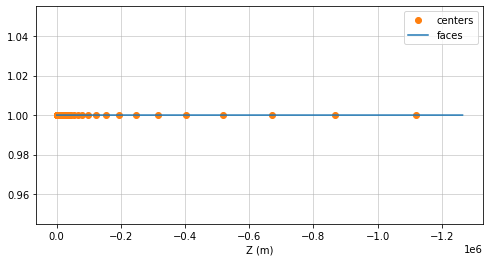

In [11]:
plot_mesh(mesh)

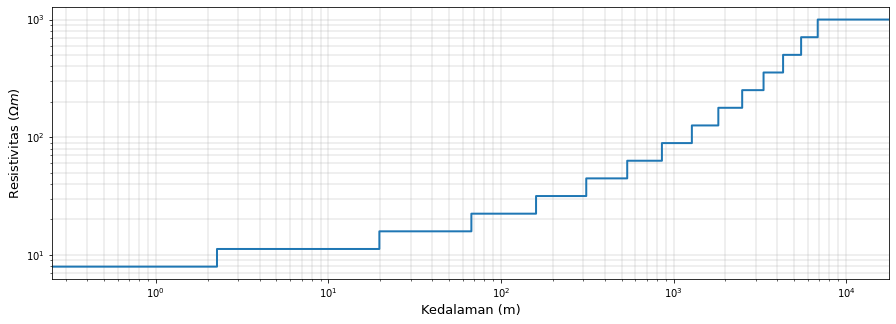

In [12]:
z, sigma, rho = model_ref(mesh, survey, layers_tops, rho_layers, True)

In [13]:
std = 0.1
d_obs, d_true = survey_dobs(survey, sigma, std)

app_res_true, phase_true = appres_phase_from_data(survey, d_true, frequency)
app_res_obs, phase_obs = appres_phase_from_data(survey, d_obs, frequency)

>> Compute fields
Delete Matrices
Factorize A matrix


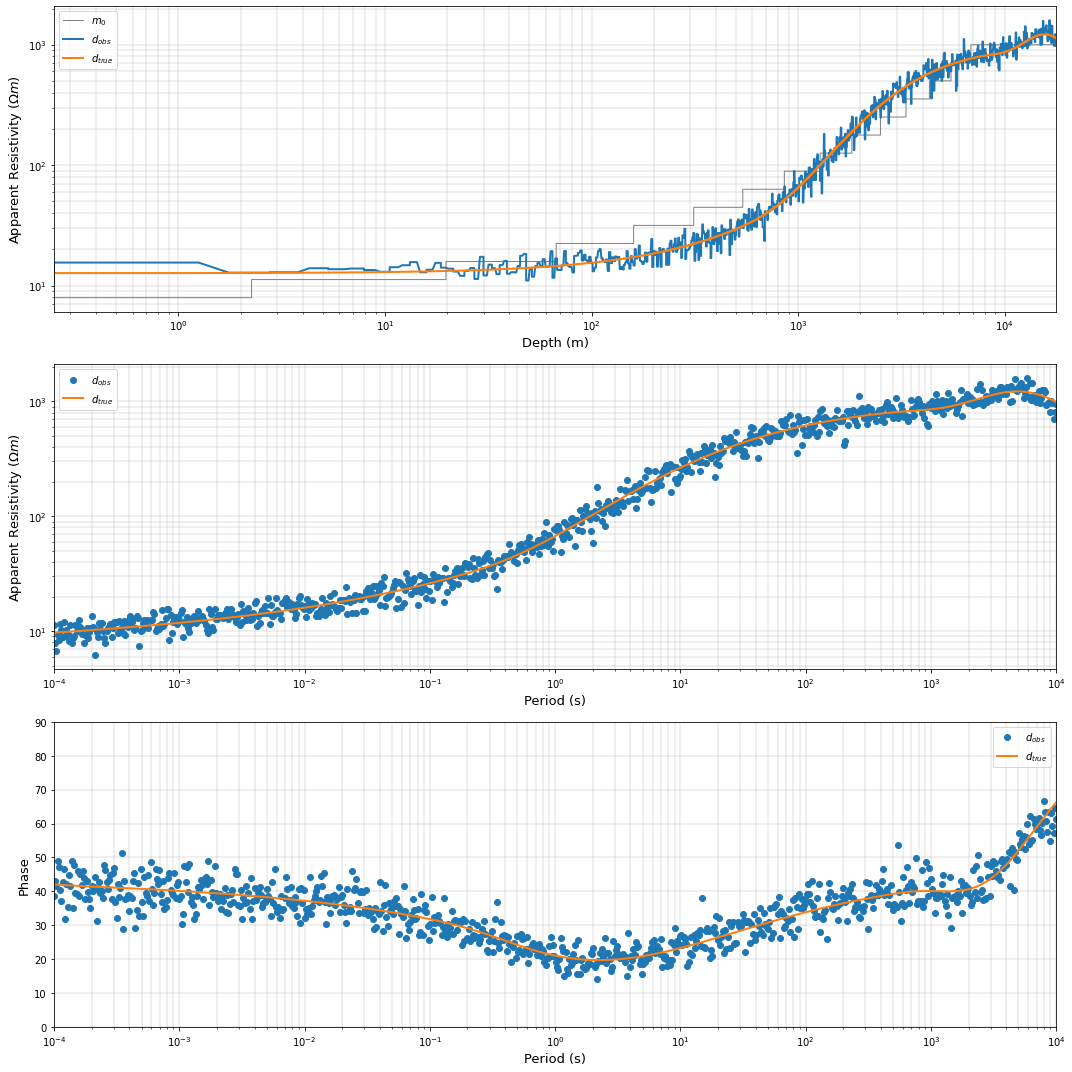

In [14]:
plot_model(frequency, rho, app_res_true, phase_true, app_res_obs, phase_obs, 'o', True)

Menyimpan data sintetik dari model bawah permukaan diatas. Data yang disimpan terdiri dari frekuensi, resistivitas, dan fase. 

In [15]:
save_data('data1', frequency, app_res_obs, phase_obs)

# **Model Resistivitas 2**

Model resistivitas kedua ini merupakan model sistem panas bumi dengan 5 lapisan 
(<a href="https://doi.org/10.1088/1755-1315/62/1/012036">https://doi.org/10.1088/1755-1315/62/1/012036</a>). 

![d](https://drive.google.com/uc?export=view&id=1-Q9bRIYN_5CnOKypjW8oFM9yOsQNglLt)


Data sintetik dari model bawah permukaan ini digunakan untuk menguji model ANN terlatih.

**Parameter Model**

| Lapisan | Resistivitas ($\Omega m$) | Ketebalan (m) | Kedalaman (m) |
|-|-|-|-|
| 1 | 70 | 750 | 750 |
| 2 | 8 | 250 | 1000 |
| 3 | 60 | 1500 | 2500 |
| 4 | 250 | 600 | 3100 |
| 5 | 850 | 900 | 4000 |

>> Smallest cell size = 0 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 371


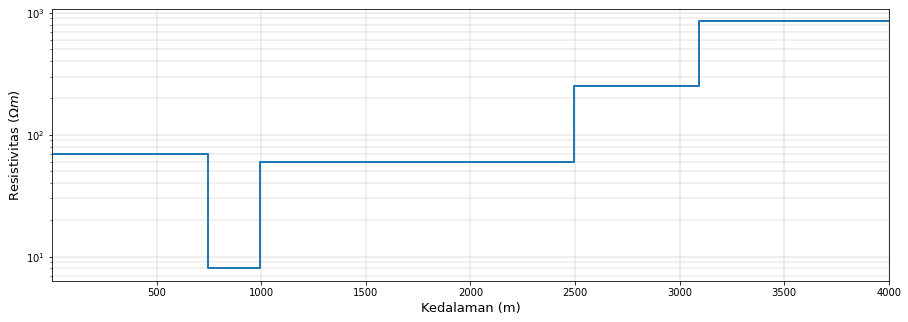

In [64]:
layers_tops = np.r_[0, -750, -1000, -2500, -3100]
rho_layers = np.r_[70, 8, 60, 250, 850]
frequency = np.logspace(-3, 4, 200)
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
z, sigma, rho = model_ref(mesh, survey, layers_tops, rho_layers, False)

In [65]:
std = 0.08
d_obs, d_true = survey_dobs(survey, sigma, std)
app_res_true, phase_true = appres_phase_from_data(survey, d_true, frequency)
app_res_obs, phase_obs = appres_phase_from_data(survey, d_obs, frequency)

>> Compute fields
Delete Matrices
Factorize A matrix


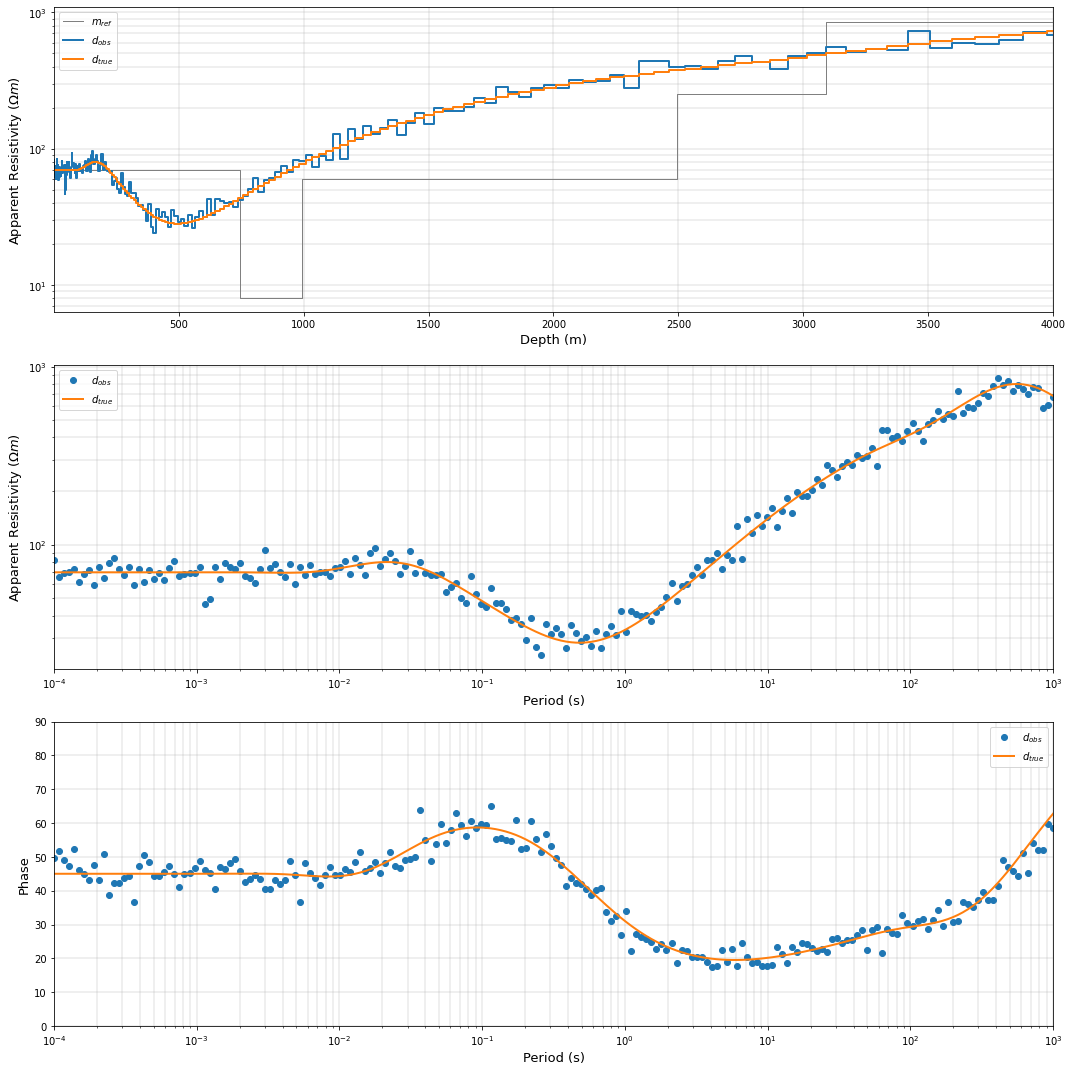

In [66]:
plot_model(frequency, rho, app_res_true, phase_true, app_res_obs, phase_obs, 'o', False)

In [67]:
save_data('data2', frequency, app_res_obs, phase_obs)

# **Model Resistivitas 3**

**Parameter Model**

| Lapisan | Resistivitas ($\Omega m$) | Ketebalan (m) | Kedalaman (m) |
|-|-|-|-|
| 1 | 70 | 500 | 500 |
| 2 | 8 | 250 | 750 |
| 3 | 60 | 1500 | 2250 |
| 4 | 250 | 1750 | 4000 |
| 5 | - | - | - |

>> Smallest cell size = 0 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 371


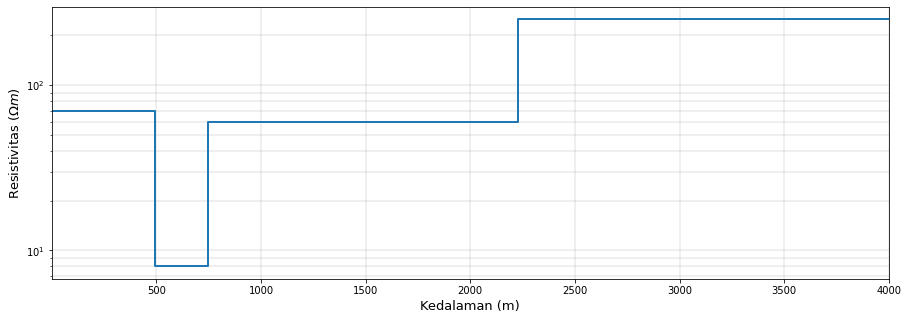

In [71]:
layers_tops = np.r_[0, -500, -750, -2250]
rho_layers = np.r_[70, 8, 60, 250]
frequency = np.logspace(-3, 4, 200)
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
z, sigma, rho = model_ref(mesh, survey, layers_tops, rho_layers, False)

In [72]:
std = 0.12
d_obs, d_true = survey_dobs(survey, sigma, std)
app_res_true, phase_true = appres_phase_from_data(survey, d_true, frequency)
app_res_obs, phase_obs = appres_phase_from_data(survey, d_obs, frequency)

>> Compute fields
Delete Matrices
Factorize A matrix


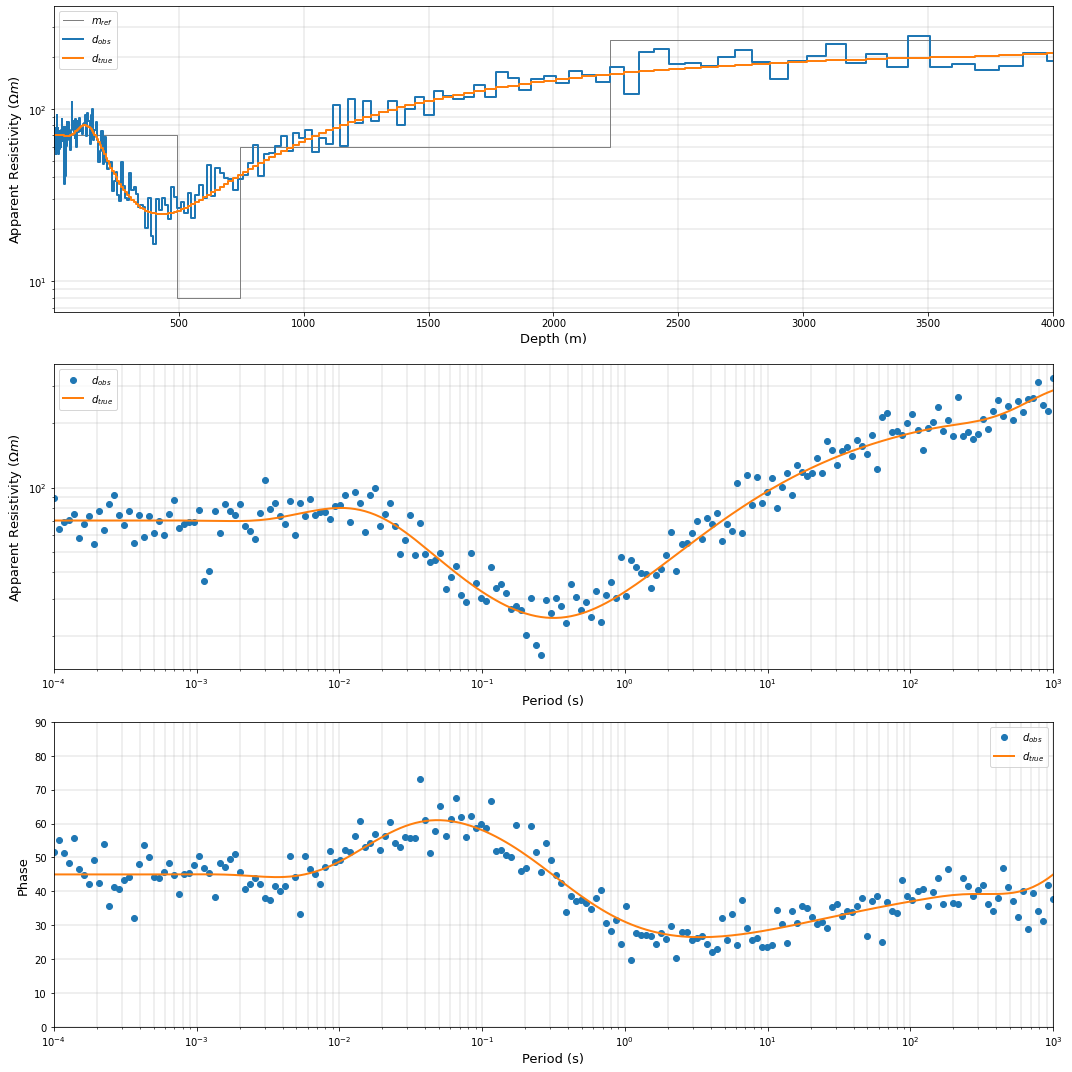

In [73]:
plot_model(frequency, rho, app_res_true, phase_true, app_res_obs, phase_obs, 'o', False)

In [74]:
save_data('data3', frequency, app_res_obs, phase_obs)